In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## read images 

In [0]:
import cv2
import numpy as np
import pandas as pd
#import tensorflow as tf
  
import gzip
import pickle
import csv
from scipy.spatial import distance as dist
import imutils

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


train_images = pd.read_pickle('/content/drive/My Drive/proj3/modified-mnist//train_max_x')
test_images = pd.read_pickle('/content/drive/My Drive/proj3/modified-mnist//test_max_x')
train_labels = pd.read_csv("/content/drive/My Drive/proj3/modified-mnist//train_max_y.csv")


In [0]:
import cv2
from scipy import ndimage

retval1, train_threshold = cv2.threshold(train_images, 250, maxval=255, type=cv2.THRESH_BINARY_INV)
retval2, test_threshold = cv2.threshold(test_images, 250, maxval=255, type=cv2.THRESH_BINARY_INV)


In [0]:
# print(test_threshold.shape)
# print(train_threshold.shape)

## image preprocessing

In [0]:
import heapq 

def image_division(img):   # input is a ndarray type
    b = img
    imag = b.astype(np.uint8)
    label_im, nb_labels = ndimage.label(imag)

    out = ndimage.find_objects(label_im)
    area = []
    crop_img = []

    #print(out)
    for label in out:
        if label==None:
            continue
        x = label[0].start
        y = label[1].start
        w = label[0].stop - label[0].start
        h = label[1].stop - label[1].start
        l =  max(w,h)
        area.append(w*h)
        #if l*l<30:
            #continue
        #else:
        temp = b[x:x+w, y:y+h]
        if (40-w)%2!=0:
            extra_w1 = max(int((40-w)/2),0)
            extra_w2 = extra_w1 + 1
        else:
            extra_w1 = max(int((40-w)/2),0)
            extra_w2 = extra_w1
            
        if (120-h)%2!=0:
            extra_h1 = max(int((120-h)/2),0)
            extra_h2 = extra_h1 + 1
        else:
            extra_h1 = max(int((120-h)/2),0)
            extra_h2 = extra_h1

        temp = np.pad(temp, ((extra_w1, extra_w2), (extra_h1, extra_h2)), 'constant', constant_values=0)
        
        crop_img.append(temp)
    
    area = np.asarray(area)
    
    if len(area)<3 :
        [a,b] = area.argsort()[-3:][::-1]
        c = np.zeros((40,120))
        #return crop_img[a],crop_img[b]
        print(crop_img[a].shape,crop_img[b].shape)
        crop_img = np.concatenate((crop_img[a],crop_img[b],c),axis=0)
    else:
        [a,b,c] = area.argsort()[-3:][::-1]
        crop_img = np.concatenate((crop_img[a],crop_img[b],crop_img[c]),axis=0)
            
    #crop_img = np.asarray(crop_img)
    #crop_img = crop_img.reshape((1,3,28,28))
    return crop_img 
    

(40, 120) (40, 120)


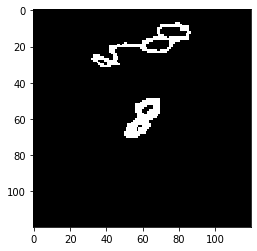

In [5]:

img = train_threshold[32292]
img = 255 - img
im = image_division(img)

pixel = np.asarray(im, dtype='uint8')
plt.imshow(pixel, cmap='gray')
plt.show()


In [6]:
#crop_img_set = np.array([])
crop_img_set = []

for img_label in range(len(train_threshold)):
    img = train_threshold[img_label]
    img = 255 - img
    #print(img_label)
    divided_img = image_division(img)
    #print(divided_img.shape)
    '''
    if divided_img.shape[0]!=40 and divided_img.shape[1]!=120 :
        print(img_label)
    
    print(divided_img.shape)
    crop_img_set = np.append(crop_img_set,divided_img,axis=0)
    '''
    crop_img_set.append(divided_img)

print(type(crop_img_set))

(40, 120) (40, 120)
<class 'list'>


In [0]:
# xx=np.array(crop_img_set)
# print(xx.shape)
# #print(type(crop_img_set[50000]))

In [0]:
'''
#crop_img_set = np.array([])
crop_test_set = []

for img_label in range(len(test_threshold)):
    img = test_threshold[img_label]
    img = 255 - img
    divided_img = image_division(img)
    crop_test_set.append(divided_img)

#crop_img_set = np.asarray(crop_img_set)
print(type(crop_test_set))
#print(crop_img_set[0].shape)
'''

'\n#crop_img_set = np.array([])\ncrop_test_set = []\n\nfor img_label in range(len(test_threshold)):\n    img = test_threshold[img_label]\n    img = 255 - img\n    divided_img = image_division(img)\n    crop_test_set.append(divided_img)\n\n#crop_img_set = np.asarray(crop_img_set)\nprint(type(crop_test_set))\n#print(crop_img_set[0].shape)\n'

In [0]:
'''
yy=np.array(crop_test_set)
print(yy.shape)
'''

'\nyy=np.array(crop_test_set)\nprint(yy.shape)\n'

## model trainning and predict

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import argparse
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Flatten
from keras import regularizers
import keras

def lenet(_numClass, _datasize):
	numClass = _numClass
	datasize = _datasize
	opt = RMSprop()

	model = Sequential()

	# first set of CONV => RELU => POOL
	model.add(Conv2D(32, 5, 5, border_mode="same",
		input_shape=(datasize, datasize, 1)))
	model.add(Activation("relu"))
	model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering="tf"))

	# second set of CONV => RELU => POOL
	model.add(Conv2D(64, 5, 5, border_mode="same"))
	model.add(Activation("relu"))
	model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering="tf"))

	# set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(500))
	model.add(Activation("relu"))

	# softmax classifier
	model.add(Dense(numClass))
	model.add(Activation("softmax"))

	model.compile(loss="categorical_crossentropy", optimizer=opt,
		metrics=["accuracy"])
	return model


Using TensorFlow backend.


In [0]:
def new_lenet(_numClass, _datasize):
    numClass = _numClass
    datasize = _datasize
    opt = RMSprop()

    model = Sequential()

    # first set of CONV => RELU => POOL
    model.add(Conv2D(64, 5, 5, border_mode="same",input_shape=(datasize, datasize, 1)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering="tf"))

    # first set of CONV => RELU => POOL
    model.add(Conv2D(64, 5, 5, border_mode="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering="tf"))

    # second set of CONV => RELU => POOL
    model.add(Conv2D(128, 5, 5, border_mode="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering="tf"))

    model.add(Conv2D(128, 5, 5, border_mode="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering="tf"))


    # third set of CONV => RELU => POOL
    model.add(Conv2D(256, 5, 5, border_mode="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering="tf"))

    # model.add(Conv2D(256, 5, 5, border_mode="same"))
    # model.add(Activation("relu"))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering="tf"))


    # set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    # model.add(Dense(512))
    # model.add(Activation("relu"))
    # model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(numClass))
    model.add(Activation("softmax"))

    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

    return model

In [0]:
from keras.callbacks import History 
history = History()

numClass = 10
datasize = 128
epochs = 25
batch_size = 128

X_train = np.divide(train_threshold, 255.0)
X_train = X_train[:,:,:,np.newaxis]

y_train = np.asarray(train_labels)[:,1]

(trainData, testData, trainLabels, testLabels) = train_test_split(X_train, y_train, test_size=0.33, shuffle=True)

y_train = np_utils.to_categorical(y_train, numClass)
trainLabels = keras.utils.to_categorical(trainLabels, numClass)
testLabels = keras.utils.to_categorical(testLabels, numClass)


In [10]:
print("[INFO] compiling model...")

model = new_lenet(numClass, datasize)
#model.fit(X_train, y_train, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=1)
history = model.fit(trainData, trainLabels, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=1,validation_data=(testData, testLabels))

[INFO] compiling model...





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(128, 128,..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_last")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_last")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 33500 samples, validate on 16500 samples
Epoch 1/25





33500/33500 [==============================] - 32s 958us/step - loss: 1.9799 - acc: 0.2533 - val_loss: 1.8902 - val_acc: 0.2737
Epoch 2/25
33500/33500 [==============================] - 22s 656us/step - loss: 1.6728 - acc: 0.3684 - val_loss: 1.0365 - val_acc: 0.6664
Epoch 3/25
33500/33500 [==============================] - 22s 652us/step - loss: 0.7090 - acc: 0.7702 - val_loss: 0.6289 - val_acc: 0.8148
Epoch 4/25
33500/33500 [==============================] - 22s 649us/step - loss: 0.3501 - acc: 0.8963 - val_loss: 0.3037 - val_acc: 0.9095
Epoch 5/25
33500/33500 [==============================] - 22s 649us/step - loss: 0.2206 - acc: 0.9393 - val_loss: 0.1989 - val_acc: 0.9448
Epoch 6/25
33500/33500 [==============================] - 22s 650us/step - loss: 0.1495 - acc: 0.9578 - val_loss: 0.2072 - val_acc: 0.9421
Epoch 7/25
 64

KeyboardInterrupt: ignored

In [0]:

X_test = np.divide(test_threshold, 255.0)
X_test = X_test[:,:,:,np.newaxis]

predicted = model.predict(X_test, verbose=1)


10000/10000 [==============================] - 3s 280us/step


In [0]:
result = np.zeros(len(predicted))
predict = np.asarray(predicted)

In [0]:
for i in range(len(predict)):
    index = predict[i].argmax()
    #print(index)
    result[i] = index
    
result = result.astype(int)
print(result[:100])

[9 6 4 9 5 8 2 3 5 8 4 9 8 9 9 6 8 7 4 6 7 7 6 5 8 9 5 6 8 6 7 9 3 8 7 6 9
 8 8 8 9 2 8 9 9 4 8 9 9 9 5 7 7 9 7 4 8 6 6 8 8 5 9 9 8 8 8 3 7 1 7 9 7 8
 9 7 9 5 6 2 8 9 7 6 9 9 8 3 7 9 7 9 5 6 8 9 5 5 7 8]


In [0]:
id_list = []
for i in range(10000):
    id_list.append(i)

name=['Id','Label']
test=pd.DataFrame(columns=name)
test['Id'] = id_list
test['Label'] = result
test.to_csv('/content/drive/My Drive/proj3/result0.csv',index=None, header=True)
test

,Id,Label
0,0,9
1,1,6
2,2,4
3,3,9
4,4,5
...,...,...
9995,9995,7
9996,9996,9
9997,9997,7
9998,9998,6
